In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

# from scipy.spatial.distance import cdist

import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

from collections import Counter

from mpl_toolkits.mplot3d import Axes3D

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [3]:
import hightolowz
import protocluster_completeness_purity 

In [4]:
from scipy.optimize import curve_fit

In [5]:
from itertools import chain, repeat

In [6]:
L = 480.279

Load data

In [8]:
zees = ['9p72','8p93','8p22','6p97','5p92','5p03','3p95','3p10','2p07']

gals_mstar = [None] * len(zees)
gals_sfr = [None] * len(zees)

for i, z in enumerate(zees):
    print z
    gals_mstar[i] = pd.read_csv('data/r200/henriques2015a_z%s_stellarMass_r200.csv' % z, skiprows=122, skipfooter=1, engine='python')
    gals_sfr[i] = pd.read_csv('data/r200/henriques2015a_z%s_sfr_r200.csv' % z, skiprows=122, skipfooter=1, engine='python')

9p72
8p93
8p22
6p97
5p92
5p03
3p95
3p10
2p07


In [8]:
cstats = pcl.load(open('data/clustering_stats_r200.p', 'rb'))

cstats_z9p72_sfr = cstats[0]
cstats_z8p93_sfr = cstats[1]
cstats_z8p22_sfr = cstats[2]
cstats_z6p97_sfr = cstats[3]

cstats_z5p92_sfr = cstats[4]
cstats_z5p03_sfr = cstats[5]
cstats_z3p95_sfr = cstats[6]
cstats_z3p10_sfr = cstats[7]
cstats_z2p07_sfr = cstats[8]

cstats_z9p72_mstar9 = cstats[9]
cstats_z8p93_mstar9 = cstats[10]
cstats_z8p22_mstar9 = cstats[11]
cstats_z6p97_mstar9 = cstats[12]

cstats_z5p92_mstar9 = cstats[13]
cstats_z5p03_mstar9 = cstats[14]
cstats_z3p95_mstar9 = cstats[15]
cstats_z3p10_mstar9 = cstats[16]
cstats_z2p07_mstar9 = cstats[17]

cstats_z5p92_mstar10 = cstats[18]
cstats_z5p03_mstar10 = cstats[19]
cstats_z3p95_mstar10 = cstats[20]
cstats_z3p10_mstar10 = cstats[21]
cstats_z2p07_mstar10 = cstats[22]

In [9]:
eigs = pcl.load(open('data/eigs_r200.p', 'rb'))

eig_vals_z9p72_mstar9 =eigs[0]
eig_vals_z8p93_mstar9 =eigs[1]
eig_vals_z8p22_mstar9 =eigs[2]
eig_vals_z6p97_mstar9 =eigs[3]
eig_vals_z5p92_mstar9 =eigs[4]
eig_vals_z5p03_mstar9 =eigs[5]
eig_vals_z3p95_mstar9 =eigs[6]
eig_vals_z3p10_mstar9 =eigs[7]
eig_vals_z2p07_mstar9 =eigs[8]

eig_vals_z9p72_sfr = eigs[9]
eig_vals_z8p93_sfr = eigs[10]
eig_vals_z8p22_sfr = eigs[11]
eig_vals_z6p97_sfr = eigs[12]
eig_vals_z5p92_sfr = eigs[13]
eig_vals_z5p03_sfr = eigs[14]
eig_vals_z3p95_sfr = eigs[15]
eig_vals_z3p10_sfr = eigs[16]
eig_vals_z2p07_sfr = eigs[17]

eig_vals_z5p03_mstar10 = eigs[18]
eig_vals_z3p95_mstar10 = eigs[19]
eig_vals_z3p10_mstar10 = eigs[20]
eig_vals_z2p07_mstar10 = eigs[21]

del eigs

### Radii plot

want to compare to theoretical C & P for ellipse with mean axes values

In [87]:
def theoretical_ratios(overdensity = False, a=7.62, b=5.17, c=3.66, N = 200000, Rmax=30):
    
    # use mean calculated values
#     a = np.mean(eig_vals_z3p95_sfr[:,0])
#     b = np.mean(eig_vals_z3p95_sfr[:,1])
#     c = np.mean(eig_vals_z3p95_sfr[:,2])

    print "a:", a, "b:", b, "c:", c

    cood_max=np.sqrt(Rmax**2 / 2)

    # uniform distribution
    coordinates = np.reshape(np.random.rand(N*3), (N,3)) * cood_max
    
    in_ellipse = np.array([(coods[0]/a)**2 + (coods[1]/b)**2 + (coods[2]/c)**2 for coods in coordinates])
    
    print coordinates.shape
    
    if overdensity:
        coords_in_ellipse = coordinates[in_ellipse <=1]
        
        for r in range(overdensity):
            coordinates = np.vstack([coordinates, coords_in_ellipse])
            
        in_ellipse = np.array([(coods[0]/a)**2 + (coods[1]/b)**2 + (coods[2]/c)**2 for coods in coordinates])
        
    print coordinates.shape

    R = np.array([np.sum(coods**2)**0.5 for coods in coordinates])
    

    

    radii = np.arange(1,30,0.1)

    P = [float(np.sum((R <= r) & (in_ellipse <= 1))) / np.sum(R <= r) for r in radii]
    C = [float(np.sum((R <= r) & (in_ellipse <= 1))) / np.sum(in_ellipse <= 1) for r in radii]

    r_sphere = (a*b*c)**(1./3)

    P_sphere = [float(np.sum((R <= r) & (R <= r_sphere))) / np.sum(R <= r) for r in radii]
    C_sphere = [float(np.sum((R <= r) & (R <= r_sphere))) / np.sum(R <= r_sphere) for r in radii]
    
    return P, C, P_sphere, C_sphere

    

In [81]:
P, C, P_sphere, C_sphere = theoretical_ratios()
P_od, C_od, P_sphere_od, C_sphere_od = theoretical_ratios(overdensity=5)

a: 7.62 b: 5.17 c: 3.66
(200000, 3)
(200000, 3)
a: 7.62 b: 5.17 c: 3.66
(200000, 3)
(208050, 3)


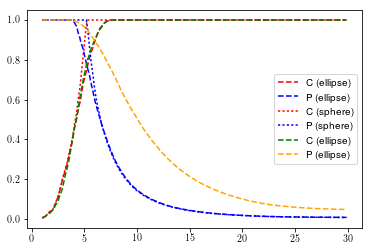

In [82]:
plt.plot(radii, C, label='C (ellipse)', c='red', linestyle='dashed')
plt.plot(radii, P, label='P (ellipse)', c='blue', linestyle='dashed')

plt.plot(radii, C_sphere, label='C (sphere)', c='red', linestyle='dotted')
plt.plot(radii, P_sphere, label='P (sphere)', c='blue', linestyle='dotted')

plt.plot(radii, C_od, label='C (ellipse)', c='green', linestyle='dashed')
plt.plot(radii, P_od, label='P (ellipse)', c='orange', linestyle='dashed')

# plt.plot(radii, C_sphere_od, label='C (sphere)', c='red', linestyle='dotted')
# plt.plot(radii, P_sphere_od, label='P (sphere)', c='blue', linestyle='dotted')

plt.legend()

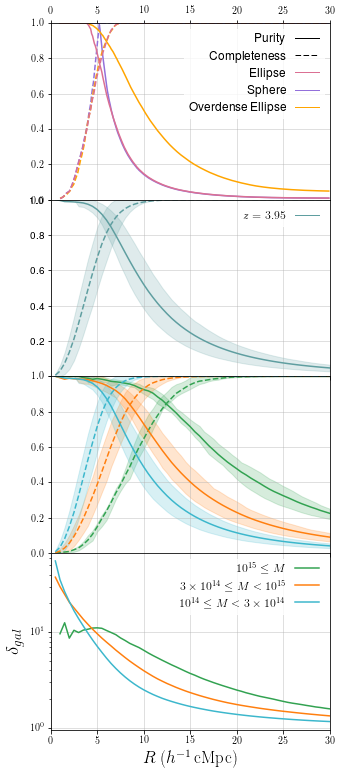

In [90]:
fig = plt.figure(figsize=(5,13))

gs = gridspec.GridSpec(4, 1)

gs.update(hspace=0, wspace=0) #bottom = 0.57, top = 1, 

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[3,0])

rangex = [float(x)/2 for x in range(61)[1:]]

#for i, cstats in enumerate([cstats_2p07_mstar, cstats_3p10_mstar, cstats_3p95_mstar]):
i = 0
cstats = cstats_z3p95_sfr


## Plot 1
completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])]).T])
purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])]).T])

# theoretical curves
ax1.plot(radii, C_sphere, label='C (sphere)', c='mediumpurple', linestyle='dashed')
ax1.plot(radii, P_sphere, label='P (sphere)', c='mediumpurple', linestyle='solid')

ax1.plot(radii, C_od, label='C (sphere)', c='orange', linestyle='dashed')
ax1.plot(radii, P_od, label='P (sphere)', c='orange', linestyle='solid')

ax1.plot(radii, C, label='C (ellipse)', c='palevioletred', linestyle='dashed')
ax1.plot(radii, P, label='P (ellipse)', c='palevioletred', linestyle='solid')

c ='cadetblue'
ax2.fill_between(rangex, completeness[:,0], completeness[:,1], alpha=0.2, color=c)
ax2.fill_between(rangex, purity[:,0], purity[:,1], alpha=0.2, color=c)

ax2.plot(rangex, np.mean([x[0] for x in np.array(cstats['cstats'])], axis=0), c=c, linestyle='dashed')
ax2.plot(rangex, np.mean([x[1] for x in np.array(cstats['cstats'])], axis=0), c=c)

# Plot 2 + 3
mask_A = np.array(cstats['clusters']['z0_central_mcrit200']) > 1e5
mask_B = (np.array(cstats['clusters']['z0_central_mcrit200']) > 3e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 1e5)
mask_C = (np.array(cstats['clusters']['z0_central_mcrit200']) > 1e4) & (np.array(cstats['clusters']['z0_central_mcrit200']) <= 3e4)
    
for i, mask in enumerate([mask_A, mask_B, mask_C]):
    
    ax4.semilogy(rangex, np.nanmean([x[2] for x in np.array(cstats['cstats'])[mask]],axis=0) + 1,
                 c=cmap[i*2], ls='solid')
    
#     dgal_range = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[2] for x in np.array(cstats['cstats'])[mask]]).T])
#     ax1.fill_between(rangex, dgal_range[:,0], dgal_range[:,1], alpha=0.2, color=cmap[i*2])
    
    completeness = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[0] for x in np.array(cstats['cstats'])[mask]]).T])
    purity = np.array([np.percentile(y, [84,16]) for y in np.vstack([x[1] for x in np.array(cstats['cstats'])[mask]]).T])

    ax3.fill_between(rangex, completeness[:,0], completeness[:,1], alpha=0.2, color=cmap[i*2])

    ax3.fill_between(rangex, purity[:,0], purity[:,1], alpha=0.2, color=cmap[i*2])

    ax3.plot(rangex, np.mean([x[0] for x in np.array(cstats['cstats'])[mask]], axis=0), 
             c=cmap[i*2], linestyle='dashed')
    
    ax3.plot(rangex, np.mean([x[1] for x in np.array(cstats['cstats'])[mask]], axis=0), c=cmap[i*2])


ax4.set_xlabel('$R \;(h^{-1} \,\mathrm{cMpc})$', size=17)
ax4.set_ylabel('$\delta_{gal}$', size=19)

ax1.xaxis.tick_top()
ax2.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])

ax2.set_xticklabels([])
ax3.set_xticklabels([])

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(0, 1)
    

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(0, 30)
    ax.grid(alpha=0.5)

line_z = []
for i in range(3):
    line_z.append(plt.Line2D((0,1),(0,0), color=cmap[i*2], linestyle='solid'))
    
legend4 = ax4.legend(handles=[line for line in line_z], 
                   labels=['$10^{15} \leq M$',
                           '$3 \\times 10^{14} \leq M < 10^{15}$',
                           '$10^{14} \leq M < 3 \\times 10^{14}$'],
                   prop={'size':12}, loc=1)

line_comp = plt.Line2D((0,1.5),(0,0), color='black', linestyle='solid', linewidth=1)
line_puri = plt.Line2D((0,1.5),(0,0), color='black', linestyle='dashed', linewidth=1)
line_theory_ell = plt.Line2D((0,1.5),(0,0), color='palevioletred', linestyle='solid', linewidth=1)
line_theory_sph = plt.Line2D((0,1.5),(0,0), color='mediumpurple', linestyle='solid', linewidth=1)
line_theory_ell_od = plt.Line2D((0,1.5),(0,0), color='orange', linestyle='solid', linewidth=1)

legend1 = ax1.legend(handles=[line_comp, line_puri, line_theory_ell, line_theory_sph, line_theory_ell_od], 
                   labels=['Purity', 'Completeness','Ellipse','Sphere', 'Overdense Ellipse'],
                   prop={'size':12}, loc=1)

line_actual = plt.Line2D((0,1.5),(0,0), color='cadetblue', linestyle='solid', linewidth=1)

legend2 = ax2.legend(handles=[line_actual],labels=['$z = 3.95$'],prop={'size':12}, loc=1)

for legend in [legend1,legend2,legend4]:
    
    legend.get_frame().set_edgecolor('white')

    # right align
    vp = legend._legend_box._children[-1]._children[0] 
    for c in vp._children: 
        c._children.reverse() 
    vp.align="right" 


# plt.savefig("../papers/hightolowz/images/compur_masscomp_dgal.png", bbox_inches='tight', dpi=300)

### $R \;/\; \delta_{z}$  stats

In [10]:
import pc_cp_cylinder
reload(pc_cp_cylinder)

<module 'pc_cp_cylinder' from 'pc_cp_cylinder.pyc'>

In [12]:
import pickle as pcl

# cylinder_mstar = [None] * len(zees)
# cylinder_sfr = [None] * len(zees)

# for i, z in enumerate(zees):
#     print z
#     cylinder_mstar[i] = pc_cp_cylinder.cluster_stats(gals_mstar[i], L=L)
#     cylinder_sfr[i] = pc_cp_cylinder.cluster_stats(gals_sfr[i], L=L)
    
# pcl.dump(cylinder_sfr, open('data/cylinder_sfr.pcl','wb'))
# pcl.dump(cylinder_mstar, open('data/cylinder_mstar.pcl','wb'))

cylinder_mstar = pcl.load(open('data/cylinder_mstar.pcl','rb'))
cylinder_sfr = pcl.load(open('data/cylinder_sfr.pcl','rb'))

In [13]:
# r = [2.5, 5., 7.5, 10., 15.]
# deltaz = [2.5, 5., 7.5, 10., 15.]

r = [7.5]
deltaz = [7.5]

save all properties in a single array to allow fit

In [21]:
feature_array = [None] * len(zees)
predictor_array = [None] * len(zees)

cylinder = cylinder_sfr

for i, z in enumerate(zees):

    x = np.zeros((np.product(cylinder[i]['cstats'].shape[:3]), 4))
    
    x[:,0] = cylinder[i]['cstats'][:,:,:,0].flatten()
    x[:,1] = np.array(list(chain.from_iterable(repeat(e, cylinder[i]['cstats'].shape[2]) for e in deltaz)) *\
                  cylinder[i]['cstats'].shape[0])
    x[:,2] = r * np.product(cylinder[i]['cstats'].shape[:2])
    x[:,3] = float(z.replace('p','.'))
    
    y = np.array(list(chain.from_iterable(repeat(e, np.product(cylinder[i]['cstats'].shape[1:3])) for e in \
                        np.log10(np.array(cylinder[i]['clusters']['z0_central_mcrit200']) * 1e10))))
    
    feature_array[i] = x
    predictor_array[i] = y
    
    
feature_array = np.vstack(feature_array)
predictor_array = np.hstack(predictor_array)

#### Fit z and single feature

In [22]:
mask = np.array([x not in [9.72,8.93,8.22,6.97,5.92] for x in feature_array[:,3]])
# (feature_array[:,2] == 7.5) & (feature_array[:,1] == 5) & \

In [23]:
# Need to fit inverse otherwise fit is poor
def func_inv(x, a, b, c, d, C):
    return 10**((x[0]-C) / (a*x[1]**b))

def func(x, a, b, c, d, C):
    return np.log10(x[0] ** (a*x[1]**b)) + C

In [24]:
p0 = [1.35, 1.75, 0, 1, 13]

popt, pcov = curve_fit(func_inv, np.vstack([predictor_array[mask], feature_array[mask,3]]), 
                       feature_array[mask, 0], maxfev=20000)#, p0=p0) #, sigma = predictor_array[mask])#


print popt

[  2.34780638  -0.04246103   1.           1.          12.63684689]


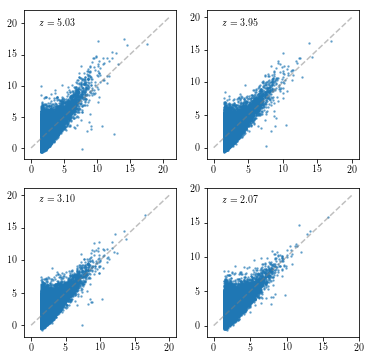

In [25]:
fig = plt.figure(figsize=(6,6))

gs1 = gridspec.GridSpec(2, 2)

# gs1.update(bottom = 0.57, top = 1, hspace=0, wspace=0)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
axes = [ax1,ax2,ax3,ax4]

for ax, z in zip(axes, zees[5:]):
    
    ax.text(0.1, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes)
    
    z_mask = (feature_array[:,3] == float(z.replace('p','.')))

    ax.plot(func_inv(np.vstack([predictor_array[mask & z_mask], feature_array[mask & z_mask,3]]),
                      popt[0], popt[1], popt[2], popt[3], popt[4]),
             feature_array[mask & z_mask, 0], '.', markersize=3, alpha=0.5)

    ax.plot(range(0,int(feature_array[mask & z_mask, 0].max() + 5)), 
             range(0,int(feature_array[mask & z_mask, 0].max() + 5)),
             c='grey', ls='dashed', alpha=0.5)
    
#     ax.scatter(predictor_array[mask & z_mask],
#             func(np.vstack([predictor_array[mask&z_mask], feature_array[mask&z_mask,3]]),
#             popt[0], popt[1], popt[2], popt[3], popt[4]))
    
    
# for ax in [ax1, ax2]:
#     ax.set_xlabel('$\delta$')

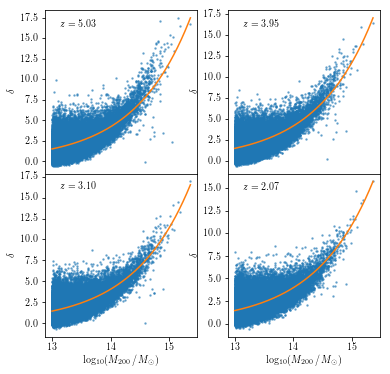

In [26]:
fig = plt.figure(figsize=(6,6))

gs1 = gridspec.GridSpec(2, 2)

gs1.update(hspace=0) # bottom = 0.57, top = 1, , wspace=0)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
axes = [ax1,ax2,ax3,ax4]

for ax, z in zip(axes, zees[5:]):
    
    ax.text(0.1, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes)
    
    z_mask = (feature_array[:,3] == float(z.replace('p','.')))

    ax.plot(predictor_array[mask & z_mask], feature_array[mask & z_mask,0], '.', markersize=3, alpha=0.5)

    ax.plot(np.linspace(predictor_array[mask & z_mask].min(), predictor_array[mask & z_mask].max(), np.sum(mask & z_mask)),
             func_inv(np.vstack([np.linspace(predictor_array[mask & z_mask].min(), predictor_array[mask & z_mask].max(), 
                                             np.sum(mask & z_mask)), feature_array[mask & z_mask,3]]),
                      popt[0], popt[1], popt[2], popt[3], popt[4]))
    
for ax in axes:
    ax.set_ylabel('$\delta$')
    ax.set_xlabel('$\mathrm{log_{10}} (M_{200}\,/\,M_{\odot})$')

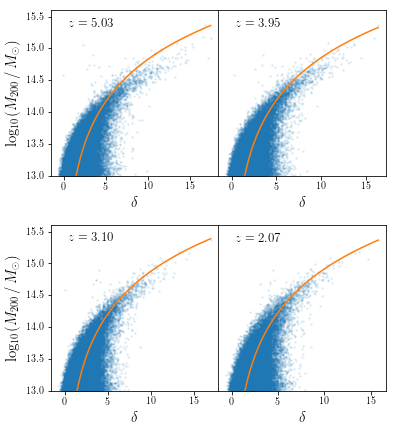

In [27]:
fig = plt.figure(figsize=(6,7))

gs1 = gridspec.GridSpec(2, 2)

gs1.update(wspace=0, hspace=0.3)

ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[0,1])
ax3 = fig.add_subplot(gs1[1,0])
ax4 = fig.add_subplot(gs1[1,1])
axes = [ax1,ax2,ax3,ax4]

for ax, z in zip(axes, zees[5:]):
    
    ax.text(0.1, 0.9, '$z = '+z.replace('p','.')+'$', transform=ax.transAxes, size=13)
    
    z_mask = (feature_array[:,3] == float(z.replace('p','.')))
    
    ax.plot(feature_array[mask&z_mask,0], predictor_array[mask&z_mask], '.', markersize=3, alpha=0.1)
    
    ax.plot(np.linspace(feature_array[mask&z_mask].min() + 2, feature_array[mask&z_mask].max(), np.sum(mask&z_mask)),
        func(np.vstack([np.linspace(feature_array[mask&z_mask].min() + 2, feature_array[mask&z_mask].max(),
                                    np.sum(mask&z_mask)), feature_array[mask&z_mask,3]]),
             popt[0], popt[1], popt[2], popt[3], popt[4]))

    
for ax in [ax2, ax4]:
    ax.set_yticklabels([])
    ax.set_yticks([])
    
for ax in [ax1, ax3]:
    ax.set_ylabel('$\mathrm{log_{10}} (M_{200}\,/\,M_{\odot})$', size=15)
    
for ax in axes:
    ax.set_xlabel('$\delta$', size=15)
    ax.set_ylim(13,15.6)
    
# plt.savefig('../papers/hightolowz/images/mass_fit.png', bbox_inches='tight', dpi=300)

In [490]:
C = 10
a = 2
b = 0.1
c = 1
d = 1

def y(x, z):
    return np.exp(a * (x-13) * z**b)



# x = (np.log(y) / (0.9 * z**0.5)) + 13

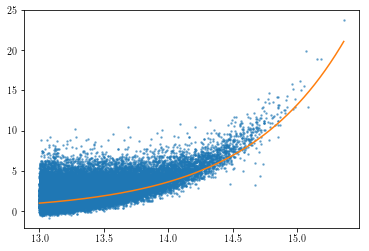

In [491]:
z = 2.07
z_mask = feature_array[:,3] == z
x = np.linspace(predictor_array[mask & z_mask].min(), predictor_array[mask & z_mask].max(), np.sum(mask & z_mask))

plt.plot(predictor_array[mask & z_mask], feature_array[mask & z_mask,0], '.', markersize=3, alpha=0.5)
plt.plot(x, y(x, z))

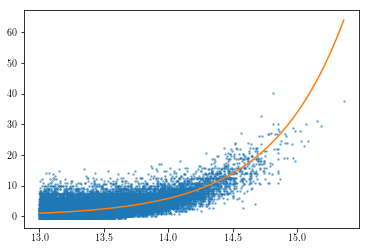

In [492]:
z = 5.03
z_mask = feature_array[:,3] == z
x = np.linspace(predictor_array[mask & z_mask].min(), predictor_array[mask & z_mask].max(), np.sum(mask & z_mask))

plt.plot(predictor_array[mask & z_mask], feature_array[mask & z_mask,0], '.', markersize=3, alpha=0.5)
plt.plot(x, y(x,z))

#### fit z, single feature and volume

In [61]:
# mask = [x not in [9.72,8.93,8.22,6.97] for x in feature_array[:,3]] 
mask = (feature_array[:,3] == 3.10) # & (feature_array[:,2] == 7.5) & (feature_array[:,1] == 7.5) 

In [84]:
# Need to fit inverse otherwise fit is poor
def func_inv(x, a, b, c, d, e, f, C):
    return (10**((x[0]-C-d*(1+x[1])**a)/(b)))*(1/(c*e*x[3]*x[2])) - 1

def func(x, a, b, c, d, e, f, C):
    return C + b*np.log10(c*(x[0]+1) + (e*(x[2]**f)*x[3])) + d*(1+x[1])**a 

In [85]:
p0 = [1.35, 1.75, 100, 1, 1, 1, 3]

popt, pcov = curve_fit(func_inv, np.vstack([predictor_array[mask], feature_array[mask,3], 
                                            feature_array[mask,1], feature_array[mask,2]]), 
                       feature_array[mask, 0], maxfev=20000, p0=p0)

print popt

[ 1.20878383  3.4831294   8.31502402  0.81459868  0.08293907  1.
  1.74363248]


In [86]:
z_mask = (feature_array[:,3] == 3.10) & (feature_array[:,1] == 7.5) & (feature_array[:,2] == 7.5)

In [87]:
np.vstack([predictor_array[mask & z_mask], feature_array[mask & z_mask,3]])

array([[ 14.58185886,  14.33297288,  13.96609619, ...,  13.94628692,
         13.74477628,  13.71686131],
       [  3.1       ,   3.1       ,   3.1       , ...,   3.1       ,
          3.1       ,   3.1       ]])

In [88]:
feature_array[mask & z_mask,0]

array([ 0.81373424,  7.30499361,  5.96855786, ...,  4.7275818 ,
        3.77298483,  2.15016999])

In [89]:
func_inv(np.vstack([predictor_array[mask&z_mask], feature_array[mask&z_mask,3],
                            feature_array[mask&z_mask,1], feature_array[mask&z_mask,2]]),
                  popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])

array([ 5.45258616,  4.47367628,  3.29486474, ...,  3.23898896,
        2.7102994 ,  2.64245856])

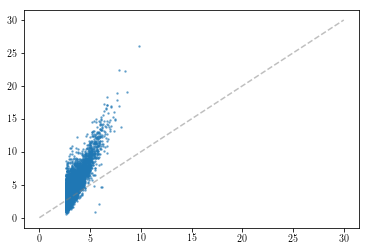

In [90]:


plt.plot(func_inv(np.vstack([predictor_array[mask&z_mask], feature_array[mask&z_mask,3],
                            feature_array[mask&z_mask,1], feature_array[mask&z_mask,2]]),
                  popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6]),
         feature_array[mask & z_mask, 0], '.', markersize=3, alpha=0.5)

plt.plot(range(0,int(feature_array[mask&z_mask, 0].max() + 5)), 
         range(0,int(feature_array[mask&z_mask, 0].max() + 5)),
         c='grey', ls='dashed', alpha=0.5)